[課題のURL](https://diver.diveintocode.jp/curriculums/1626)

# Sprint18 データセット作成

# 犬と猫のデータセットを作成

それぞれ5枚ずつくらい。少ないデータで学習することを目指しましょう

In [2]:
from icrawler.builtin import BingImageCrawler

crawler = BingImageCrawler(storage={'root_dir': 'dogs'})
crawler.crawl(keyword="dog", max_num=5)

crawler = BingImageCrawler(storage={'root_dir': 'cats'})
crawler.crawl(keyword="cat", max_num=5)

2020-06-24 11:17:35,171 - INFO - icrawler.crawler - start crawling...
2020-06-24 11:17:35,174 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-06-24 11:17:35,176 - INFO - feeder - thread feeder-001 exit
2020-06-24 11:17:35,176 - INFO - icrawler.crawler - starting 1 parser threads...
2020-06-24 11:17:35,180 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-06-24 11:17:35,641 - INFO - parser - parsing result page https://www.bing.com/images/async?q=dog&first=0
2020-06-24 11:17:36,251 - INFO - downloader - image #1	https://images.wagwalkingweb.com/media/articles/dog/why-is-my-dog-unable-to-stand/why-is-my-dog-unable-to-stand.jpg
2020-06-24 11:17:36,471 - INFO - downloader - image #2	https://i.ytimg.com/vi/MPV2METPeJU/maxresdefault.jpg
2020-06-24 11:17:37,353 - INFO - downloader - image #3	https://www.newshub.co.nz/home/lifestyle/2019/11/dog-years-are-a-myth-2-year-old-dogs-already-middle-aged-scientists/_jcr_content/par/video/image.dynimg.1280.q75.jpg
2020-06-

# 【問題1】自作データセットでの分類の学習

自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。  

In [41]:
#model.save("model.h5") 
#model.save("model_aug.h5") [問題2]拡張データで学習したもの

## 訓練

~~~
# ************************
# モデル構築(CNN)  *******
# ************************

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np

# 乱数固定 ----------
import keras.backend as K
import tensorflow as tf

K.clear_session()

np.random.seed(seed=0)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# 画像ファイルパス ----------
#train_data_dir = "train/" # training dir path @@@パス名を変更
train_data_dir = "train_aug/" # training dir path @@@パス名を変更
validation_data_dir = "validation/" # validation dir path @@@パス名を変更

# モデル条件設定 ----------
img_width, img_height = 150, 150 # モデル画像サイズ
nb_train_samples = 3000 # training data (1500x2)
nb_validation_samples = 1000 # validation data (500x2)
epochs = 5 # エポック数 @@@ 50から5に変更
batch_size = 32 # バッチ数
nb_category = 2 # カテゴリ数（cat, dog）

# 画像データのジェネレータ ----------

# 訓練用
train_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")
# 検証用
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

# モデル定義 ----------

# モデルVGG16（not include Top）
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# モデルTop
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_category, activation='softmax'))

# vgg16とtop_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# layer14までの重みパメータを固定する（訓練で更新しない）
for layer in model.layers[:15]:
    layer.trainable = False

# コールバック

# early_stopping_cb = EarlyStopping(
#    monitor='val_acc', patience=10, verbose=1, mode='max')

# checkpoint_cb = ModelCheckpoint(
#    './{epoch:03d}-{val_acc:.5f}.hdf5', save_best_only=True)

# csvlogger_cb = CSVLogger('./history.csv') 
csvlogger_cb = CSVLogger('./history_aug.csv') 

# コンパイル ----------
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.rmsprop(lr=5e-7, decay=5e-5),
              metrics=['accuracy'])

model.summary()


# *******************
# 訓練実行  *********
# *******************

history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=[csvlogger_cb])

# モデルを保存
#model.save("model.h5")
model.save("model_aug.h5")
~~~

## 予測

2枚目いついては、predが正解になったので、精度が上がった?

model = load_model("./model.h5")の場合
~~~
Found 8 images belonging to 1 classes.
9/9 [==============================] - 2s 273ms/step
*** test data [cat] *****
i [0.06619895 0.9338011 ] pred: dog  score = 0.934
i [0.43946823 0.5605318 ] pred: dog  score = 0.561
i [0.9792215  0.02077847] pred: cat  score = 0.979
i [0.10891126 0.8910888 ] pred: dog  score = 0.891
------------------------------
*** test data [dog] *****
i [0.21315478 0.7868452 ] pred: dog  score = 0.787
i [0.95005363 0.0499464 ] pred: cat  score = 0.950
i [0.07245441 0.92754555] pred: dog  score = 0.928
i [0.06619895 0.9338011 ] pred: dog  score = 0.934
~~~

model = load_model("./model_aug.h5")の場合(フリップを実施)
~~~
Found 8 images belonging to 1 classes.
9/9 [==============================] - 2s 221ms/step
*** test data [cat] *****
i [0.27473113 0.7252689 ] pred: dog  score = 0.725
i [0.68975586 0.31024408] pred: cat  score = 0.690
i [0.9942591  0.00574085] pred: cat  score = 0.994
i [0.2375226  0.76247734] pred: dog  score = 0.762
------------------------------
*** test data [dog] *****
i [0.3970009  0.60299903] pred: dog  score = 0.603
i [0.9748454  0.02515464] pred: cat  score = 0.975
i [0.12821175 0.87178826] pred: dog  score = 0.872
i [0.27473113 0.7252689 ] pred: dog  score = 0.725
~~~

In [50]:
from keras.models import load_model
K.clear_session()
# model = load_model("./model.h5")
model = load_model("./model_aug.h5")

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential, load_model
import pandas as pd
import numpy as np
import os

# ****************************
# テストデータで予測実行 *****
# ****************************

test_data_dir = "test/" # テスト用データdir
img_width, img_height = 150, 150 # 画像サイズ（訓練同）
nb_test_samples = 9 # 画像データ数
batch_size = 1 # バッチサイズ
nb_category = 2 # カテゴリ数（cat, dog）

# 画像データのジェネレータ（テスト用）
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# 分類予測
pred = model.predict_generator(
        test_generator,
        steps=nb_test_samples,
        verbose=1)

# ****************************
# テストデータの予測結果 *****
# ****************************

labels = ['cat', 'dog']
# データ0～14 -> Cat画像
# データ15～29 -> Dog画像

print("*** test data [cat] *****")
for i in pred[0:4]: # @@@
    cls = np.argmax(i)
    score = np.max(i)
    print("i",i,"pred: {}  score = {:.3f}".format(labels[cls], score))

print("-" * 30)

print("*** test data [dog] *****")
for i in pred[5:9]: # @@@
    cls = np.argmax(i)
    score = np.max(i)
    print("i",i,"pred: {}  score = {:.3f}".format(labels[cls], score))

Found 8 images belonging to 1 classes.
9/9 [==============================] - 2s 221ms/step
*** test data [cat] *****
i [0.27473113 0.7252689 ] pred: dog  score = 0.725
i [0.68975586 0.31024408] pred: cat  score = 0.690
i [0.9942591  0.00574085] pred: cat  score = 0.994
i [0.2375226  0.76247734] pred: dog  score = 0.762
------------------------------
*** test data [dog] *****
i [0.3970009  0.60299903] pred: dog  score = 0.603
i [0.9748454  0.02515464] pred: cat  score = 0.975
i [0.12821175 0.87178826] pred: dog  score = 0.872
i [0.27473113 0.7252689 ] pred: dog  score = 0.725


# 【問題2】分類データセットに対するデータ拡張

データ拡張（Data Augmentation）を行ってください。  
https://github.com/albumentations-team/albumentations  

参考：
サーベイ論文
「深層学習を用いた画像識別タスクの精度向上テクニック」  
https://search.ieice.org/bin/pdf_link.php?category=D&lang=J&year=2019&fname=j102-d_2_34&abst=  
→chap3.2参照、まずはフリップを実施してみる。  

→猫5枚、犬5枚それぞれについてフリップを実施する  
→各5枚なので1枚つづ実施  

~~~
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
 
def get_augmentation():
    transform = [
        albu.HorizontalFlip(p=1),
        #albu.VerticalFlip(p=1),
    ]
    return albu.Compose(transform)
 
File_name = "000005.jpg"

#画像の読み込み・変換・表示
img = cv2.imread(r"./train/dogs/" + File_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
trans = get_augmentation()
 
img = trans(image=img)['image'] 
plt.imshow(img);
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

result = cv2.imwrite("Flip"+File_name, img)
~~~

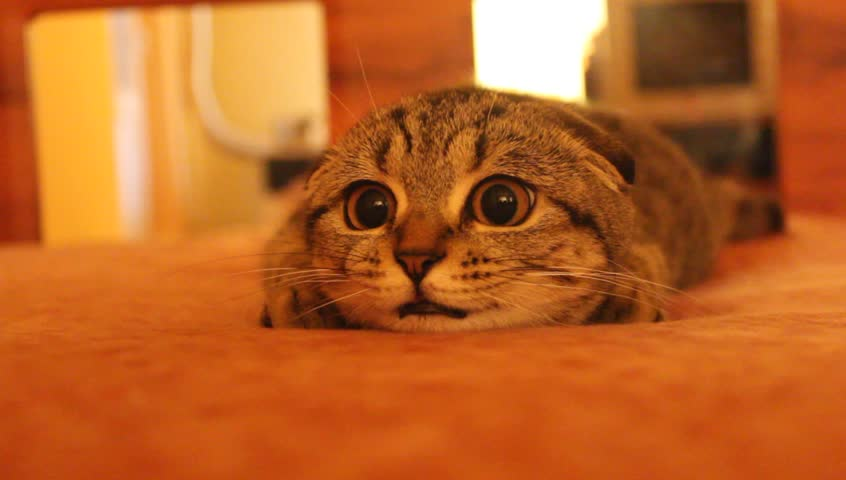

In [38]:
from IPython.display import Image
Image("./train_aug/cats/000001.jpg")

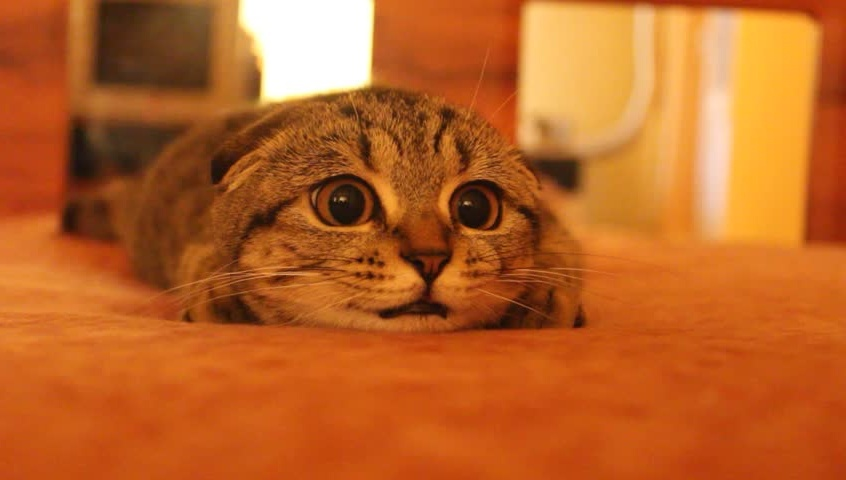

In [19]:
Image("./train_aug/cats/Flip000001.jpg")

# 【問題3】物体検出データセットの用意

次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

アノテーションツール  
http://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html  
→ x,y,w,h形式なので、使用するAPIのIFに応じて変更する。  

annotation.txt
~~~
./train_aug/dogs/000001.jpg 345,204,1003,839 dog
./train_aug/dogs/000002.jpg 180,11,782,590 dog
./train_aug/dogs/000003.jpg 332,40,418,310 dog
./train_aug/dogs/000004.jpg 182,13,1220,1225 dog
./train_aug/dogs/000005.jpg 17,20,176,159 dog
./train_aug/cats/000001.jpg 249,65,445,271 cat
./train_aug/cats/000002.jpg 678,163,1005,1264 cat
./train_aug/cats/000003.jpg 356,2,727,640 cat
./train_aug/cats/000004.jpg 264,245,380,391 cat
./train_aug/cats/000005.jpg 276,71,748,684 cat
~~~

# 【問題4】物体検出データセットに対するデータ拡張

データ拡張（Data Augmentation）を行ってください。  
前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。  
詳細はREADME.mdを確認してください。  

物体検出の学習を行なうかどうかは任意とします  

annotatio2.txt
~~~
./train_aug/dogs/000001.jpg 345,204,1003,839 dog
./train_aug/dogs/000002.jpg 180,11,782,590 dog
./train_aug/dogs/000003.jpg 332,40,418,310 dog
./train_aug/dogs/000004.jpg 182,13,1220,1225 dog
./train_aug/dogs/000005.jpg 17,20,176,159 dog
./train_aug/dogs/000006.jpg 752,204,1003,839 dog
./train_aug/dogs/000007.jpg 318,11,782,590 dog
./train_aug/dogs/000008.jpg 530,40,418,310 dog
./train_aug/dogs/000009.jpg 698,13,1220,1225 dog
./train_aug/dogs/0000010.jpg 287,20,176,159 dog
./train_aug/cats/000001.jpg 249,65,445,271 cat
./train_aug/cats/000002.jpg 678,163,1005,1264 cat
./train_aug/cats/000003.jpg 356,2,727,640 cat
./train_aug/cats/000004.jpg 264,245,380,391 cat
./train_aug/cats/000005.jpg 276,71,748,684 cat
./train_aug/cats/000006.jpg 152,65,445,271 cat
./train_aug/cats/000007.jpg 817,163,1005,1264 cat
./train_aug/cats/000008.jpg 197,2,727,640 cat
./train_aug/cats/000009.jpg 156,245,380,391 cat
./train_aug/cats/0000010.jpg 576,71,748,684 cat
~~~

~~~
# 画像の読み込み・変換・表示
# ./train_aug/dogs/000001.jpg 345,204,1003,839 dog
# x,y,w,h → x_min, y_min, x_max, y_max に変換

x_min = 345
y_min = 204
w = 1003
h = 839
x_max = x_min + w
y_max = y_min + h

img = cv2.imread(r"./train/dogs/" + File_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.rectangle(img,(x_min, y_min),(x_max, y_max),(255,255,0),10)

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img);
result = cv2.imwrite("Bbox"+File_name, img)
~~~

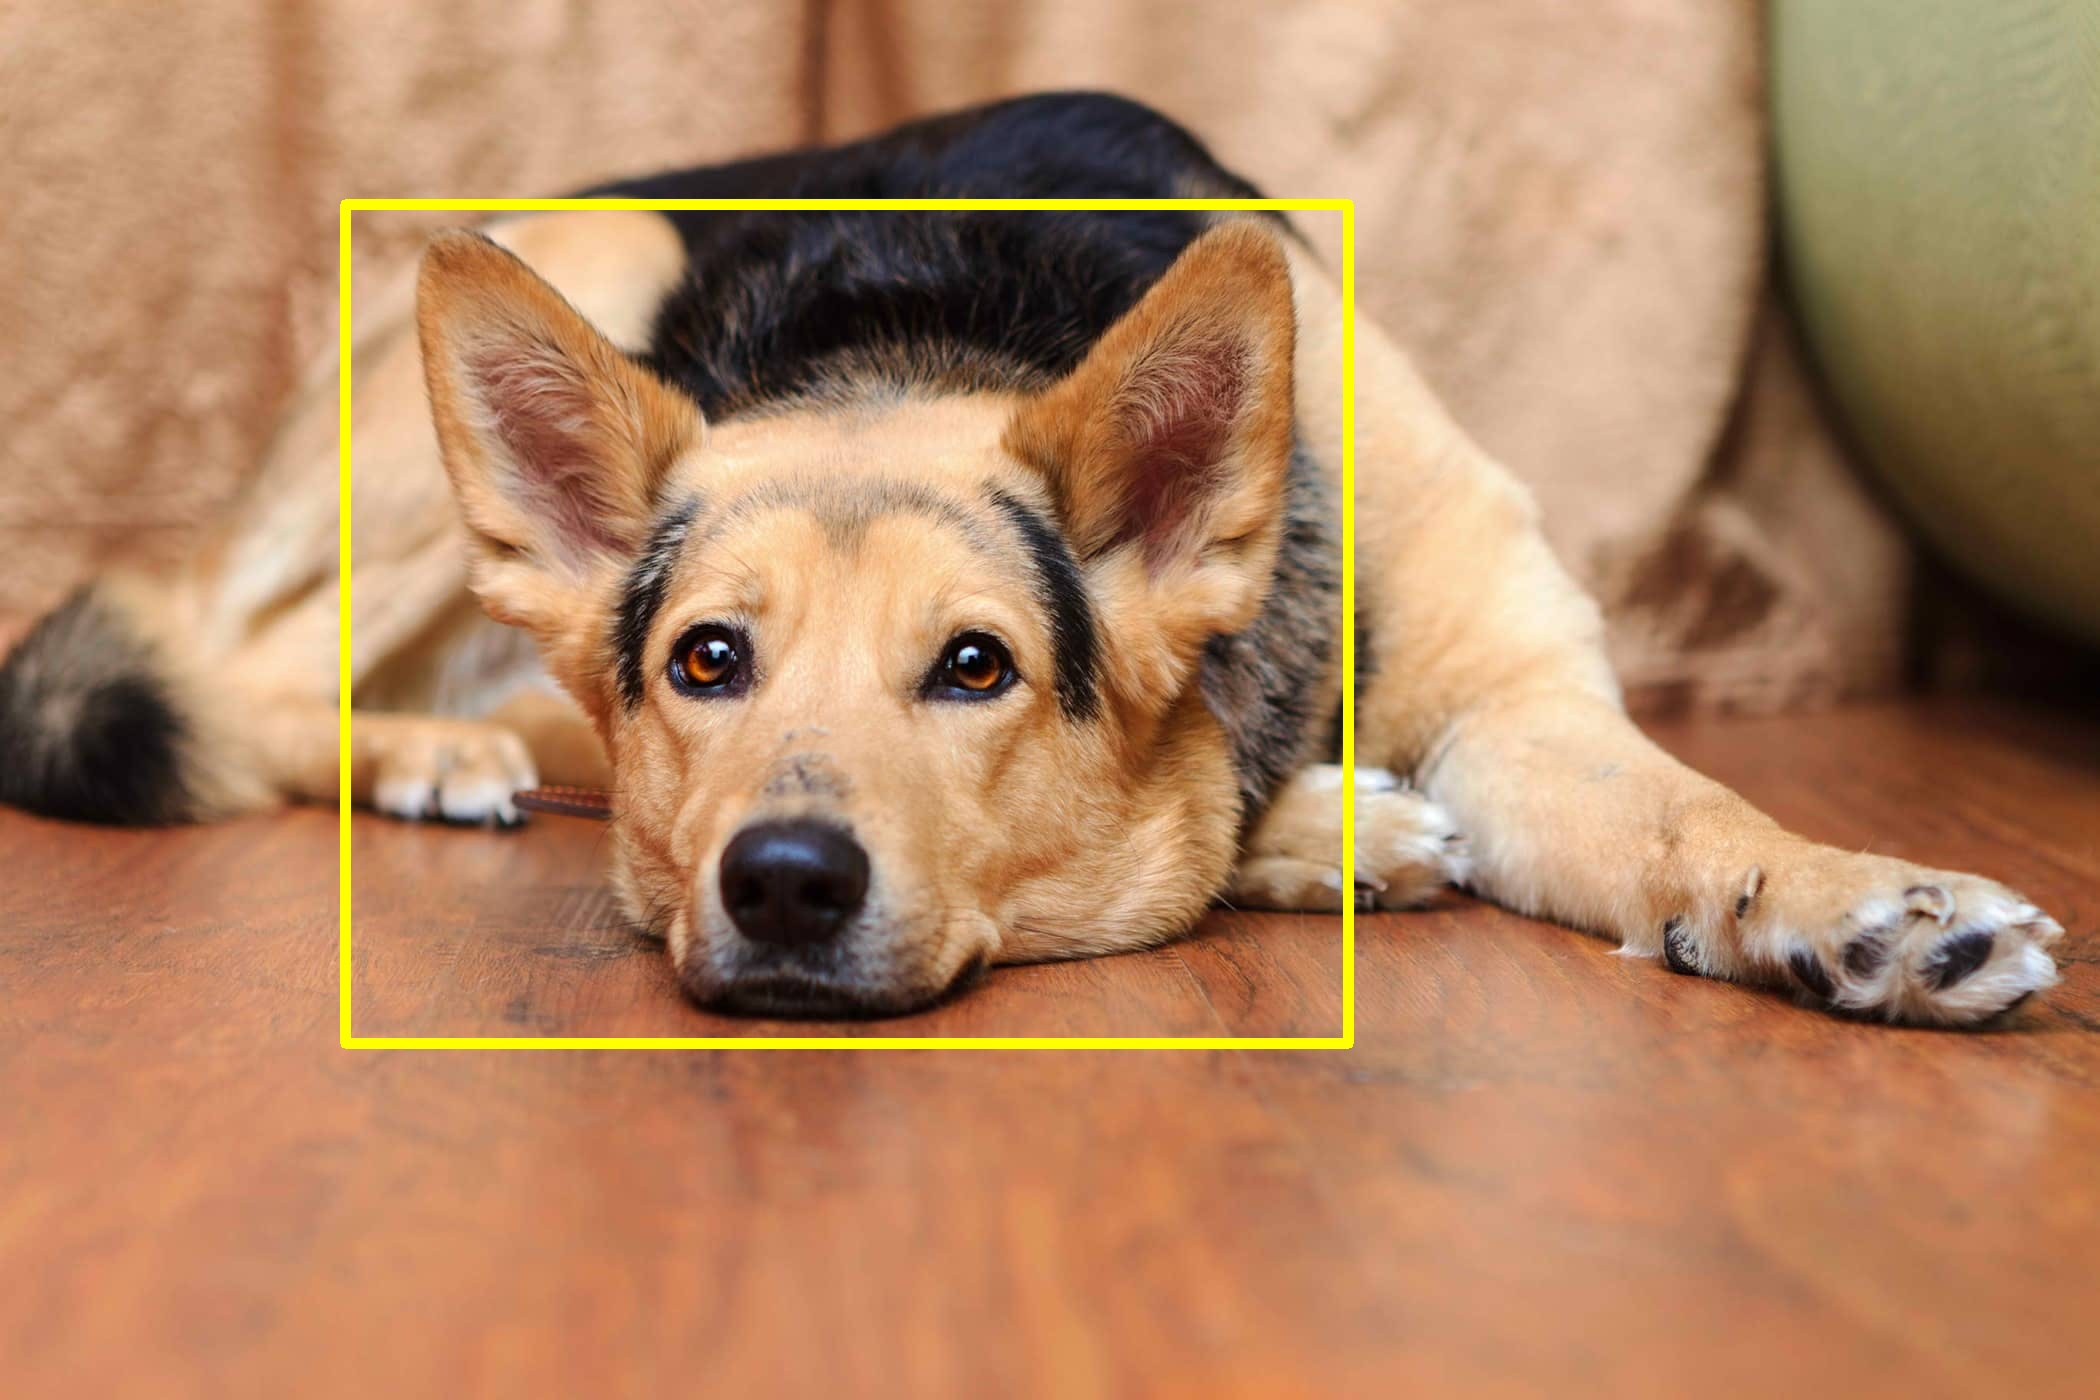

In [39]:
Image("./Bbox000001.jpg")

~~~
def convert_bbox_flip(x_min, y_min, x_max, y_max, imag_row, imag_cols):

  y_min = y_min
  y_max = y_max

  w = x_max - x_min
  print(w)
  x_max = imag_cols - x_min
  x_min = x_max - w

  return x_min, y_min, x_max, y_max

#bbox = albu.augmentations.functional.bbox_flip((x_min, y_min, x_max, y_max), 1, imag_row, imag_cols)
x_min, y_min, x_max, y_max = convert_bbox_flip(x_min, y_min, x_max, y_max, img.shape[0], img.shape[1])

#画像の読み込み・変換・表示
img = cv2.imread(r"./train/dogs/" + File_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
trans = get_augmentation()
 
img = trans(image=img)['image'] 
#img = cv2.rectangle(img,(x_min, y_min),(x_max, y_max),(255,255,0),10)
img = cv2.rectangle(img,(x_min, y_min),(x_max, y_max),(255,255,0),10)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img);
result = cv2.imwrite("Bbox_flip"+File_name, img)
~~~

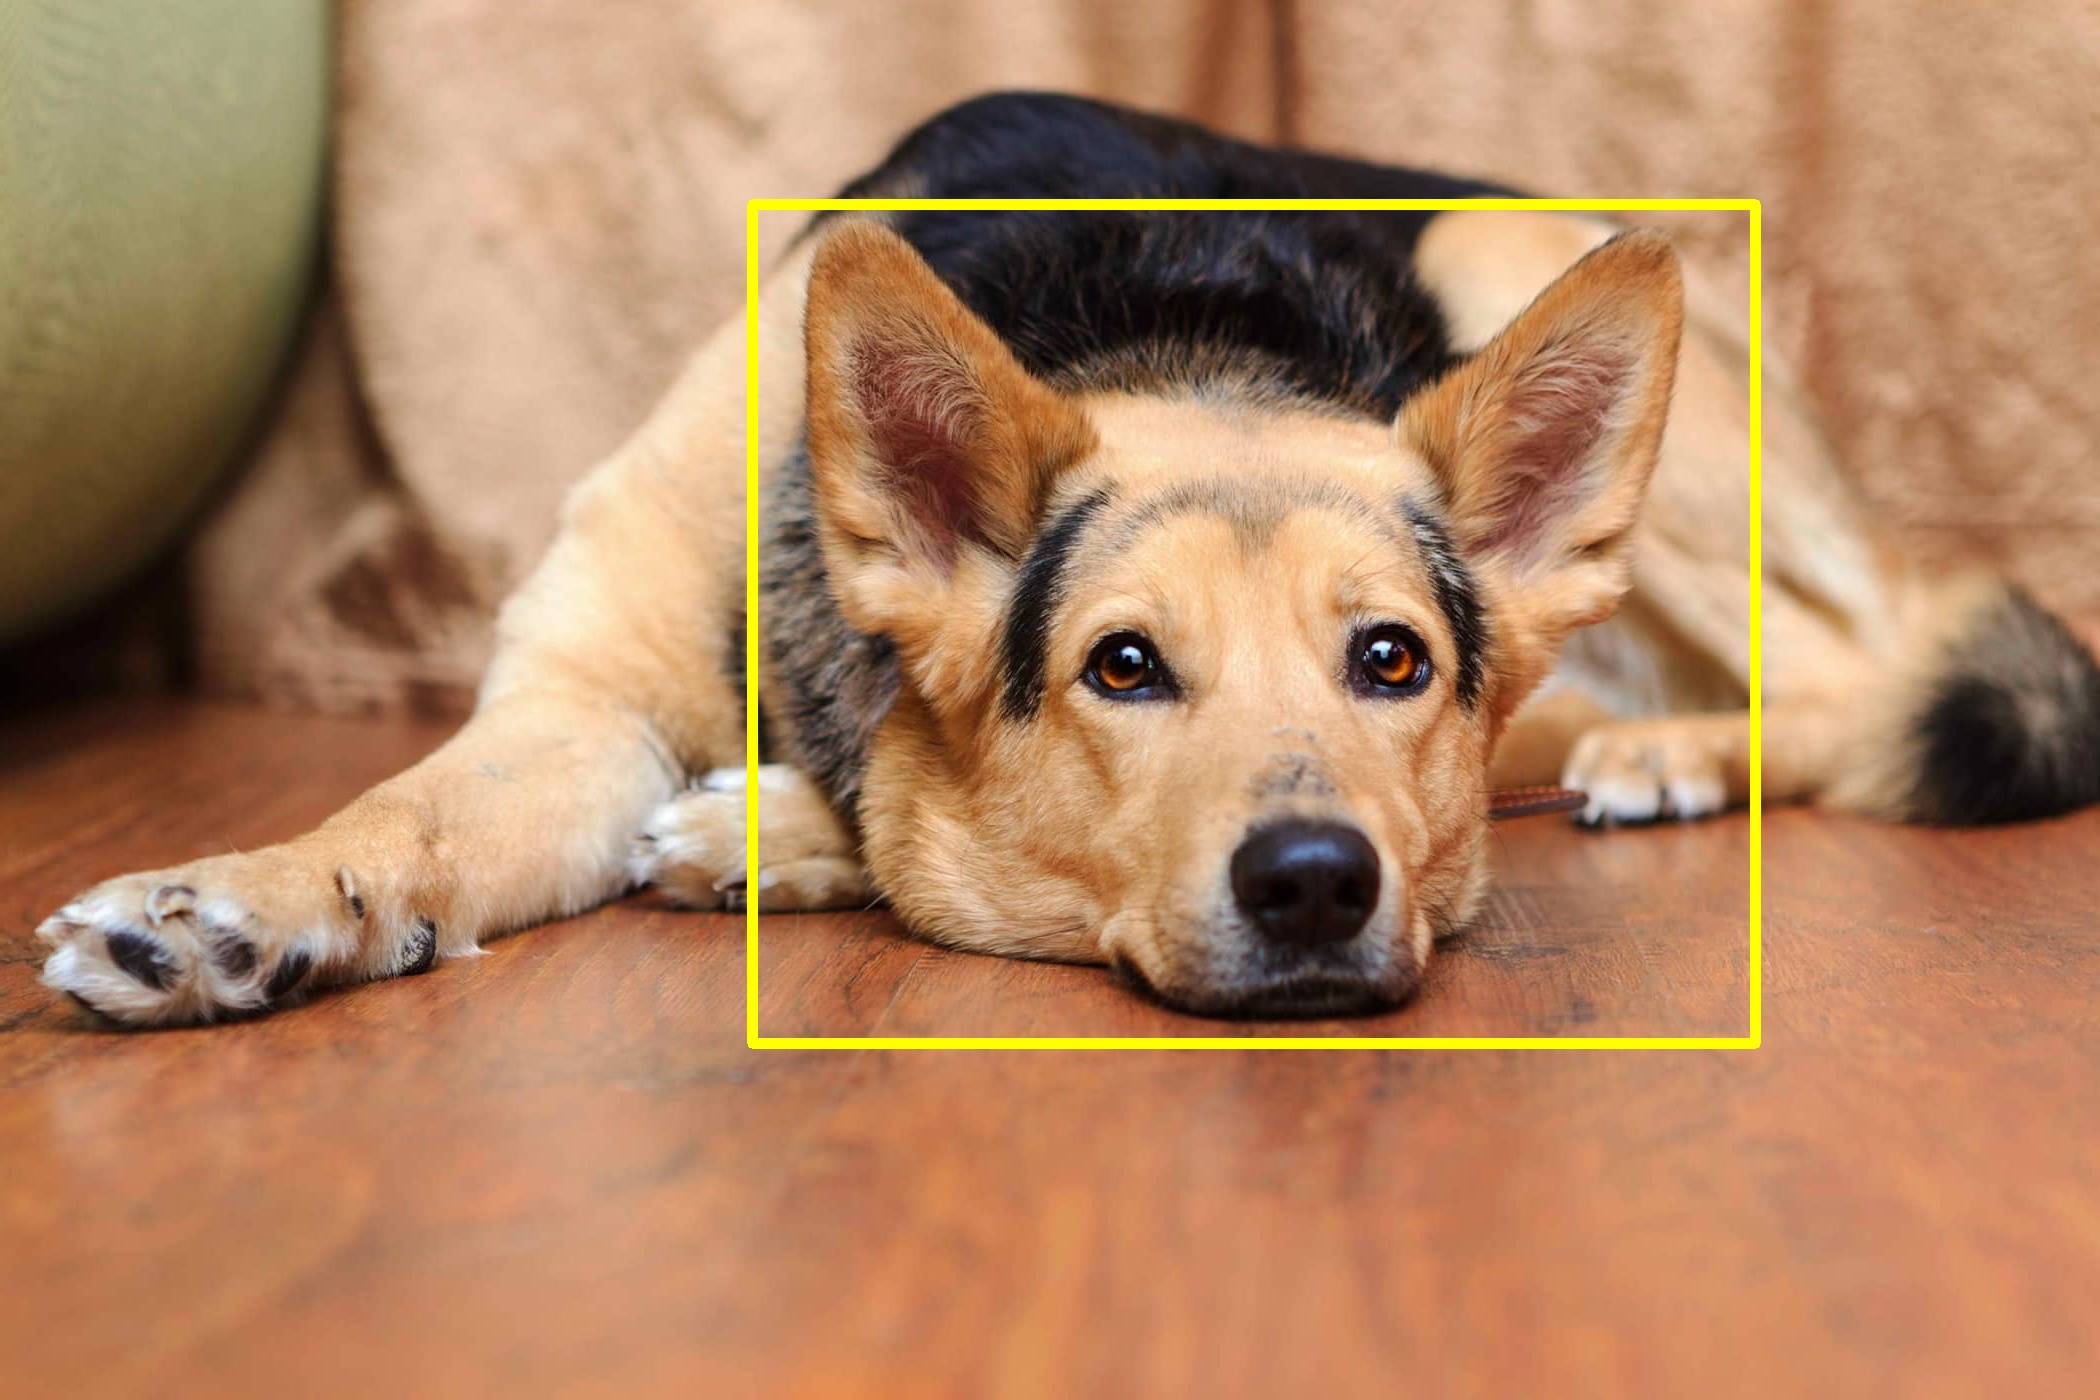

In [40]:
Image("./Bbox_flip000001.jpg")